# Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import copy
import pickle
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pystan
import arviz as az
from tqdm import tqdm
from tensorflow import keras
from Helpers.DDM_rng import random_ddm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

root = "drive/MyDrive/CMPLabData/Lexicon/"

Mounted at /content/drive


# Prepare data

In [ ]:
words = []
frq = []
sum_frq = 0
with open(root+"Datasets/Items.csv", 'r') as file:
    reader = csv.reader(file)
    for idx, row in enumerate(reader):
        if idx ==0 or len(row[0]) > 20: 
            continue
        words.append([row[0], int(row[2].replace(',',''))])
        frq.append(int(row[2].replace(',','')))
        sum_frq += int(row[2].replace(',',''))
        
words.sort(key = lambda x: x[1], reverse=True)

all_words = [word[0] for word in words]
hf_words = all_words[:int(len(words)/5)]
lf_words = all_words[int(len(words)/5):]
# Another metric for defining hf an lf is good to be tested (something other than half of the words are hf
# and other half is lf)

In [ ]:
# Build pandas dataframe

### From Pickle 
with open(root+'Datasets/words.pkl', 'rb') as f:
  words = pickle.load(f)

with open(root+'Datasets/nonwords.pkl', 'rb') as f:
  nonwords = pickle.load(f)

for nw in nonwords:
    nw.insert(1, 0)
word_nword_df = pd.DataFrame(words + nonwords,
               columns =['string', 'freq', 'represention'])

word_nword_df['freq'] = word_nword_df['freq'].astype('int32')
word_nword_df['freq'] = word_nword_df['freq'].replace(to_replace=[0], value=[1])
word_nword_df

,string,freq,represention
0,a,10610626,"[0.11558813, 0.30192456, -0.114647746, 0.01000..."
1,aah,222,"[0.08188029, -0.12485198, -0.3285692, 0.374986..."
2,Aaron,10806,"[0.12105307, 0.058084395, -0.013443807, 0.1779..."
3,aback,387,"[-0.11328265, -0.23398337, -0.58877015, 0.2669..."
4,abacus,513,"[0.19533455, 0.10326072, -0.19377021, 0.234316..."
...,...,...,...
80817,declassificarion,1,"[-0.1627126, -0.21505767, 0.2029604, 0.0559478..."
80818,antifundamentadast,1,"[-0.09716947, -0.056558426, -0.18841882, -0.04..."
80819,transcontanental,1,"[0.22957236, -0.21539333, -0.027639901, 0.1270..."
80820,iv,1,"[-0.42683536, -0.50000775, -0.16295096, -0.305..."


In [ ]:
Number_Of_Participants = 5
Number_Of_Trials = 400
dataframes = []
for i in range(Number_Of_Participants):
    df = pd.read_csv(root+"behavioural/"+str(i+1)+"DATA.LDT", names=['trial', 'string_id', 'string_type', 'accuracy', 'rt', 'string'])
    # drop empty, 2 first non lexical data, unneccesry column and eny possilble nan
    # get 400 first trials
    # for getting more trials more droping and modification is needed
    df = df.dropna().drop('string_id', axis=1).drop([0, 1]).iloc[:Number_Of_Trials] 
    convert_dict = {'string_type': 'int16',
                'accuracy': 'int16',
                'rt': float
               }

    df = df.astype(convert_dict)

    category = [] # 0 is HF and 1 is LF and 2 is NW

    for index, row in df.iterrows():
        if row[4] in hf_words:
            category.append(0)
        elif row[4] in lf_words:
            category.append(1)
        else:
            category.append(2)
        
    df['category'] = category
    df['rt'] = df['rt'].apply(lambda x: x/1000) # convert to seconds
    df['string_type'] = df['string_type'].replace(to_replace=[0], value=[2])
    df['accuracy'] = df['accuracy'].replace(to_replace=[0], value=[-1])
    df['participant'] = i+1
    dataframes.append(df)

In [ ]:
behavioural_df = pd.concat(dataframes)

In [ ]:
behavioural_df

,trial,string_type,accuracy,rt,string,category,participant
2,1,1,-1,0.707,bookie,1,1
3,2,2,1,0.769,gandbrake,2,1
4,3,1,1,0.526,philosophical,0,1
5,4,2,-1,0.510,umbeaten,2,1
6,5,1,1,0.512,belonging,1,1
...,...,...,...,...,...,...,...
397,396,2,-1,1.181,Mauruce,2,5
398,397,1,1,0.553,thought,0,5
399,398,2,-1,0.590,hankening,2,5
400,399,2,-1,1.296,deltoil,2,5


In [ ]:
behavioural_df.loc[np.logical_and(behavioural_df['accuracy']!=1, behavioural_df['accuracy']!=-1)]

,trial,string_type,accuracy,rt,string,category,participant


In [ ]:
behavioural_df.loc[np.logical_and(behavioural_df['string_type']!=1, behavioural_df['string_type']!=2)]

,trial,string_type,accuracy,rt,string,category,participant


In [ ]:
np.unique(behavioural_df['category'])

array([0, 1, 2])

In [ ]:
np.unique(behavioural_df['participant'])

array([1, 2, 3, 4, 5])

In [ ]:
behavioural_df.groupby('category').count()

,trial,string_type,accuracy,rt,string,participant
category,,,,,,
0,192,192,192,192,192,192
1,838,838,838,838,838,838
2,970,970,970,970,970,970


In [ ]:
# After the merge there are some NaN's probably becuase word_nword_df is are trainset that is 0.8 of
# All our lexical data
# It's good to be tested with full data (prediction of ANN on all lexical data)
# THERE ARE DUPLICATES IN word_nword_df THAT CUASE MORE ROWS IN MERGED DATAFRAME THAN behavioural_df
behavioural_df = pd.merge(behavioural_df, word_nword_df.drop_duplicates(subset=['string']) , on='string', how='left')

In [ ]:
# Alternative For mergeing without droping duplicates
# freq = []
# represention = []
# for index, row in tqdm(behavioural_df.iterrows()):
#     target_row = word_nword_df.loc[word_nword_df['string'] == row[4]]
#     freq.append(target_row.iloc[:, 1])
#     represention.append(target_row.iloc[:, 2])
# behavioural_df['freq'] = freq
# behavioural_df['represention']=represention

In [ ]:
behavioural_df

,trial,string_type,accuracy,rt,string,category,participant,freq,represention
0,1,1,-1,0.707,bookie,1,1,130,"[0.022534829, -0.15998152, -0.14819951, -0.062..."
1,2,2,1,0.769,gandbrake,2,1,1,"[-0.29506972, 0.115305506, -0.19235633, 0.5014..."
2,3,1,1,0.526,philosophical,0,1,4959,"[0.039424393, -0.061520983, -0.15255918, 0.253..."
3,4,2,-1,0.510,umbeaten,2,1,1,"[-0.20129028, -0.072871946, -0.50137556, 0.394..."
4,5,1,1,0.512,belonging,1,1,2332,"[-0.13127953, -0.014333408, -0.14648758, 0.182..."
...,...,...,...,...,...,...,...,...,...
1995,396,2,-1,1.181,Mauruce,2,5,1,"[-0.19156513, 0.09101384, -0.07849926, 0.11711..."
1996,397,1,1,0.553,thought,0,5,174954,"[-0.036734484, -0.004555184, -0.4262246, 0.071..."
1997,398,2,-1,0.590,hankening,2,5,1,"[-0.09320254, -0.12529378, -0.25142515, -0.068..."
1998,399,2,-1,1.296,deltoil,2,5,1,"[-0.45630825, -0.23284501, -0.65707755, 0.2984..."


In [ ]:
behavioural_df.loc[np.logical_and(behavioural_df['accuracy']!=1, behavioural_df['accuracy']!=-1)]

,trial,string_type,accuracy,rt,string,category,participant,freq,represention


In [ ]:
behavioural_df.loc[np.logical_and(behavioural_df['string_type']!=1, behavioural_df['string_type']!=2)]

,trial,string_type,accuracy,rt,string,category,participant,freq,represention


In [ ]:
np.unique(behavioural_df['category'])

array([0, 1, 2])

In [ ]:
np.unique(behavioural_df['participant'])

array([1, 2, 3, 4, 5])

In [ ]:
behavioural_df.groupby('category').count()

,trial,string_type,accuracy,rt,string,participant,freq,represention
category,,,,,,,,
0,192,192,192,192,192,192,192,192
1,838,838,838,838,838,838,838,838
2,970,970,970,970,970,970,970,970


In [ ]:
representions = np.array(list(behavioural_df['represention']))

In [ ]:
representions.shape

(2000, 300)

In [ ]:
behavioural_df.groupby('category').count()

,trial,string_type,accuracy,rt,string,participant,freq,represention
category,,,,,,,,
0,192,192,192,192,192,192,192,192
1,838,838,838,838,838,838,838,838
2,970,970,970,970,970,970,970,970


In [ ]:
behavioural_df.loc[behavioural_df['category']==0].describe()

,string_type,accuracy,rt,category,participant,freq
count,192.0,192.000000,192.000000,192.0,192.000000,1.920000e+02
mean,1.0,0.937500,0.599083,0.0,2.869792,5.827709e+04
std,0.0,0.348895,0.214853,0.0,1.329773,2.598577e+05
min,1.0,-1.000000,0.301000,0.0,1.000000,3.345000e+03
25%,1.0,1.000000,0.479000,0.0,2.000000,5.141500e+03
50%,1.0,1.000000,0.535000,0.0,3.000000,8.435000e+03
75%,1.0,1.000000,0.654500,0.0,4.000000,2.311675e+04
max,1.0,1.000000,1.660000,0.0,5.000000,2.616965e+06


In [ ]:
behavioural_df.loc[behavioural_df['category']==1].describe()

,string_type,accuracy,rt,category,participant,freq
count,838.0,838.000000,838.000000,838.0,838.000000,838.000000
mean,1.0,0.730310,0.692995,1.0,3.001193,574.280430
std,0.0,0.683524,0.243648,0.0,1.434762,749.092475
min,1.0,-1.000000,0.271000,1.0,1.000000,1.000000
25%,1.0,1.000000,0.534000,1.0,2.000000,73.000000
50%,1.0,1.000000,0.630000,1.0,3.000000,264.000000
75%,1.0,1.000000,0.794750,1.0,4.000000,761.500000
max,1.0,1.000000,2.274000,1.0,5.000000,3318.000000


In [ ]:
behavioural_df.loc[behavioural_df['category']==2].describe()

,string_type,accuracy,rt,category,participant,freq
count,970.0,970.000000,970.000000,970.0,970.000000,970.0
mean,2.0,0.709278,0.770415,2.0,3.024742,1.0
std,0.0,0.705292,0.279930,0.0,1.413267,0.0
min,2.0,-1.000000,0.200000,2.0,1.000000,1.0
25%,2.0,1.000000,0.596000,2.0,2.000000,1.0
50%,2.0,1.000000,0.708500,2.0,3.000000,1.0
75%,2.0,1.000000,0.867000,2.0,4.000000,1.0
max,2.0,1.000000,2.848000,2.0,5.000000,1.0


# Get ANN predictions

In [ ]:
model = tf.keras.models.load_model(root+"check_points/NN_model")

In [ ]:
model.compile()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense1 (Dense)              (None, 300)               90300     
                                                                 
 dense2 (Dense)              (None, 200)               60200     
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense3 (Dense)              (None, 100)               20100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense4 (Dense)              (None, 10)                1010      
                                                                 
 clf (Dense)                 (None, 2)                 2

In [ ]:
all_feature_vec = model.predict(representions)

In [ ]:
all_feature_vec.shape

(2000, 2)

In [ ]:
outfile = open(root+"check_points/all_feature_vec",'wb')
pickle.dump(all_feature_vec,outfile)
outfile.close()

## reading all_feature_vec

In [ ]:
with open(root+'check_points/all_feature_vec', 'rb') as f:
  all_feature_vec = pickle.load(f)
all_feature_vec.shape

(2000, 2)

In [ ]:
all_feature_vec = all_feature_vec[:Number_Of_Participants*Number_Of_Trials, :]
all_feature_vec.shape

(2000, 2)

# NN Stan

In [ ]:
ann_ddm_model = pystan.StanModel(file='hier.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_934f1f3f7334e25221a9c3a4bbdd4fd4 NOW.


In [ ]:
# all_feature_vec = all_feature_vec.reshape(Number_Of_Participants, Number_Of_Trials, 10)
# all_feature_vec.shape

In [ ]:
N = Number_Of_Participants * Number_Of_Trials                                     
P = 2                                                                        # Number of predictors (features)
L = Number_Of_Participants
x = all_feature_vec                                                          # Feature data
frequencies = behavioural_df['freq'].to_numpy().astype(int)                  # frequencies of words, nonwords are 1
labels = behavioural_df['string_type'].to_numpy().astype(int)                # Outcome
rt = behavioural_df['rt'].to_numpy()                     
accuracy = behavioural_df['accuracy'].to_numpy().astype(int)
participant = behavioural_df['participant'].to_numpy().astype(int)

drift_scaling_priors = [0, 2, 1, 1]                                          # mean and sd of the prior
threshold_priors = [3, 2, 1, 1]                                              # mean and sd of the prior
ndt_priors = [0, 1, 1, 1] 
starting_point = 0.5

# define input for the model
data_dict = {'N': N,
             'P': P,
             'L': L,
             'x' : x, 
             'labels' : labels,  
             'frequencies': frequencies,                                                                     
             'rt': rt,
             'drift_scaling_priors' : drift_scaling_priors,                                    
             'threshold_priors' : threshold_priors,                                                
             'ndt_priors':ndt_priors,
             'starting_point': starting_point,
             'accuracy': accuracy,
             'participant': participant
            }

# set sampling parameters
n_iter = 1000
n_warmup = int(n_iter/2)
n_chains = 4

In [ ]:
# fit the model
fit = ann_ddm_model.sampling(data=data_dict,
                             iter=n_iter, 
                             warmup=n_warmup,
                             chains=n_chains,
                             verbose=True)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [ ]:
print("***hmc diagnostics:")
print(pystan.check_hmc_diagnostics(fit))

***hmc diagnostics:


{'n_eff': True, 'Rhat': True, 'divergence': False, 'treedepth': False, 'energy': True}


In [ ]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

print("***DF: ")
print(df)

***DF: 
                           mean   se_mean  ...        n_eff      Rhat
mu_drift_scaling      -1.187705  0.008741  ...   789.561451  1.002845
mu_threshold           1.212788  0.019293  ...   314.320183  1.013643
mu_ndt                -1.014552  0.021526  ...   168.515690  1.027437
sigma_drift_scaling    0.513604  0.010171  ...   745.504540  1.007103
sigma_threshold        0.688516  0.013353  ...   689.697930  1.000394
...                         ...       ...  ...          ...       ...
log_lik[1997]          0.972205  0.000795  ...  1883.160667  1.000117
log_lik[1998]         -0.222836  0.000709  ...  1917.025540  0.999505
log_lik[1999]         -1.708520  0.001237  ...  2019.295860  1.000405
log_lik[2000]         -0.081855  0.000664  ...  1975.143047  1.000602
lp__                -656.985987  0.202860  ...   387.210987  1.009603

[10037 rows x 10 columns]


In [ ]:
df.loc[df['Rhat'] > 1.01]

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
mu_threshold,1.212788,0.019293,0.342041,0.611427,1.021608,1.198859,1.362996,2.061522,314.320183,1.013643
mu_ndt,-1.014552,0.021526,0.279433,-1.609929,-1.164663,-1.023857,-0.863374,-0.402479,168.515690,1.027437
z_ndt[1],0.592192,0.026534,0.511138,-0.393751,0.231459,0.571839,0.922207,1.629611,371.087752,1.012188
z_ndt[3],-0.377711,0.025645,0.437697,-1.239789,-0.652460,-0.381551,-0.081348,0.490477,291.295827,1.012533
z_ndt[4],0.563206,0.026132,0.504156,-0.418533,0.207165,0.544939,0.887067,1.586044,372.217856,1.012348
z_ndt[5],0.086111,0.024288,0.430922,-0.788145,-0.207141,0.090909,0.377746,0.919408,314.786419,1.013646


In [ ]:
np.unique(df.loc[df['Rhat'] > 1.01].iloc[:, -1].to_numpy() > 2.5, return_counts=True)

(array([False]), array([6]))

In [ ]:
list(df.loc[df['Rhat'] > 1.01].index)

['mu_threshold', 'mu_ndt', 'z_ndt[1]', 'z_ndt[3]', 'z_ndt[4]', 'z_ndt[5]']

In [ ]:
counter = 0
print("***Rhat > 1.01: ")
for f in df["Rhat"]:
    if f > 1.01:
        # print(f)
        counter+=1
print(counter)

***Rhat > 1.01: 
6


In [ ]:
with open(root+"results/model_fit.pkl", "wb") as f:
    pickle.dump({'model' : ann_ddm_model, 'fit' : fit}, f, protocol=-1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  


# Check parameters

In [ ]:
with open(root+"results/model_fit.pkl", "rb") as f:
    data_dict = pickle.load(f)

fit = data_dict['fit']

In [ ]:
fit.to_dataframe(pars=['mu_drift_scaling', 'mu_threshold', 'mu_ndt'],
                 diagnostics=False, inc_warmup=False).drop(['chain','draw', 'warmup'], axis=1).describe()

,mu_drift_scaling,mu_ndt,mu_threshold
count,2000.000000,2000.000000,2000.000000
mean,-1.187705,-1.014552,1.212788
std,0.245616,0.279433,0.342041
min,-2.540740,-2.108807,-0.643584
25%,-1.314298,-1.164548,1.021713
50%,-1.187865,-1.023857,1.198859
75%,-1.056271,-0.863377,1.362962
max,0.129544,0.199667,2.782022


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7f20b8a0d0>,
      dtype=object)

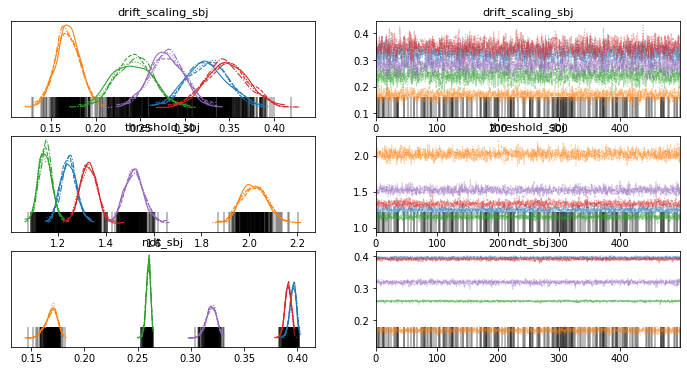

In [ ]:
az.plot_trace(fit, var_names=['drift_scaling_sbj', 'threshold_sbj', 'ndt_sbj'])

In [ ]:
# az.plot_posterior(fit, var_names=['drift_scaling_sbj', 'threshold_sbj', 'ndt_sbj'], hdi_prob=.95)

In [ ]:
# az.rcParams["plot.max_subplots"] = 200 
# az.plot_posterior(fit, var_names=['drift_ll'], hdi_prob=.95)

In [ ]:
# az.plot_posterior(fit, var_names=['drift_t'], hdi_prob=.95)

# Posterior Predictions

In [ ]:
behavioural_df.groupby(['category']).count()

,trial,string_type,accuracy,rt,string,participant,freq,represention
category,,,,,,,,
0,192,192,192,192,192,192,192,192
1,838,838,838,838,838,838,838,838
2,970,970,970,970,970,970,970,970


In [ ]:
drift_t = fit['drift_t']
threshold_t = fit['threshold_t']
ndt_t = fit['ndt_t']

## Group level

In [ ]:
# HF_words
HF_words_drift = drift_t[:, behavioural_df.index[behavioural_df['category']==0].tolist()]
HF_words_threshold = threshold_t[:, behavioural_df.index[behavioural_df['category']==0].tolist()]
HF_words_ndt = ndt_t[:, behavioural_df.index[behavioural_df['category']==0].tolist()]
HF_words_rt, HF_words_acc = random_ddm(HF_words_drift, HF_words_threshold, HF_words_ndt)

# LF_words
LF_words_drift = drift_t[:, behavioural_df.index[behavioural_df['category']==1].tolist()]
LF_words_threshold = threshold_t[:, behavioural_df.index[behavioural_df['category']==1].tolist()]
LF_words_ndt = ndt_t[:, behavioural_df.index[behavioural_df['category']==1].tolist()]
LF_words_rt, LF_words_acc = random_ddm(LF_words_drift, LF_words_threshold, LF_words_ndt)

# non_words
non_words_drift = drift_t[:, behavioural_df.index[behavioural_df['category']==2].tolist()]
non_words_threshold = threshold_t[:, behavioural_df.index[behavioural_df['category']==2].tolist()]
non_words_ndt = ndt_t[:, behavioural_df.index[behavioural_df['category']==2].tolist()]
non_words_rt, non_words_acc = random_ddm(non_words_drift, non_words_threshold, non_words_ndt)

In [ ]:
hf_words_rt_real = behavioural_df.loc[behavioural_df['category']==0]['rt']
lf_words_rt_real = behavioural_df.loc[behavioural_df['category']==1]['rt']
non_words_rt_real = behavioural_df.loc[behavioural_df['category']==2]['rt']

hf_words_acc_real = behavioural_df.loc[behavioural_df['category']==0]['accuracy']
lf_words_acc_real = behavioural_df.loc[behavioural_df['category']==1]['accuracy']
non_words_acc_real = behavioural_df.loc[behavioural_df['category']==2]['accuracy']

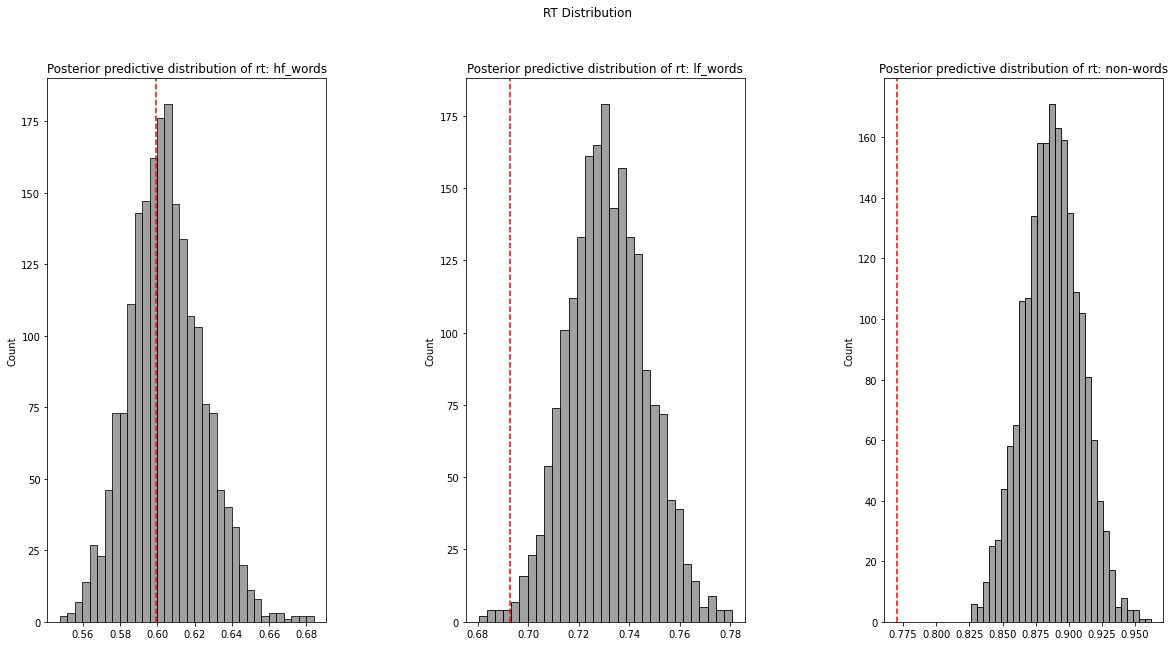

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

fig.suptitle('RT Distribution')
axes[0].set_title('Posterior predictive distribution of rt: hf_words')
axes[1].set_title('Posterior predictive distribution of rt: lf_words')
axes[2].set_title('Posterior predictive distribution of rt: non-words')


sns.histplot(ax=axes[0], data = np.mean(HF_words_rt, axis=1), color='grey')
axes[0].axvline(np.mean(hf_words_rt_real), color='red', linestyle='--');

sns.histplot(ax=axes[1], data = np.mean(LF_words_rt, axis=1), color='grey')
axes[1].axvline(np.mean(lf_words_rt_real), color='red', linestyle='--');

sns.histplot(ax=axes[2], data = np.mean(non_words_rt, axis=1), color='grey')
axes[2].axvline(np.mean(non_words_rt_real), color='red', linestyle='--');

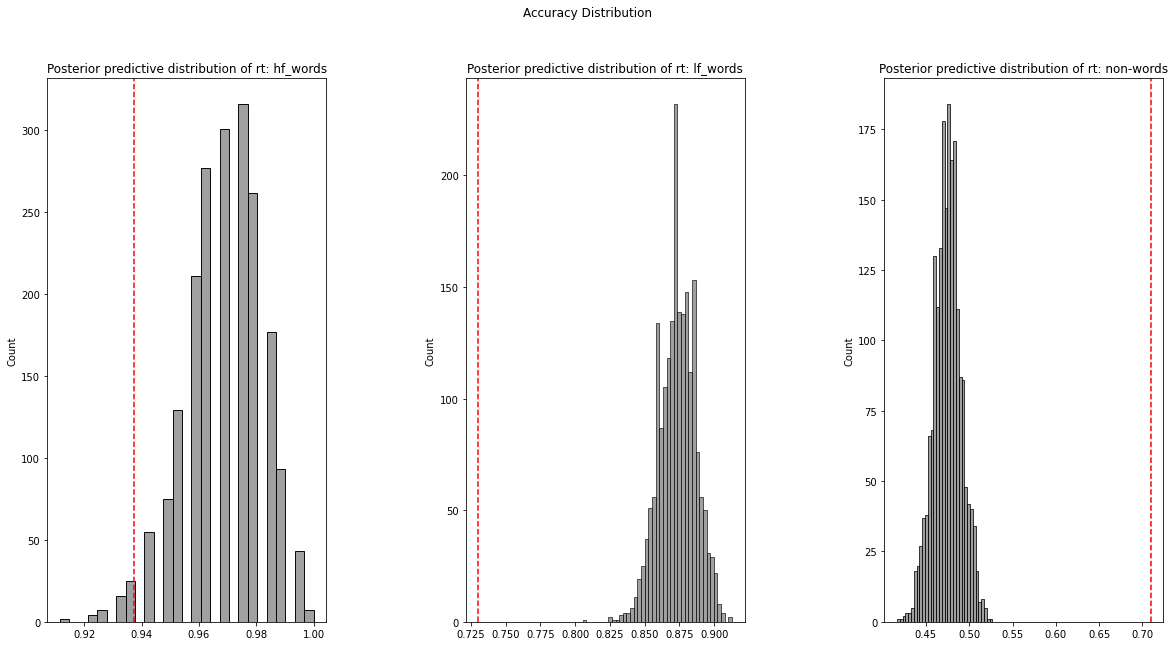

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

fig.suptitle('Accuracy Distribution')
axes[0].set_title('Posterior predictive distribution of rt: hf_words')
axes[1].set_title('Posterior predictive distribution of rt: lf_words')
axes[2].set_title('Posterior predictive distribution of rt: non-words')


sns.histplot(ax=axes[0], data = np.mean(HF_words_acc, axis=1), color='grey')
axes[0].axvline(np.mean(hf_words_acc_real), color='red', linestyle='--');

sns.histplot(ax=axes[1], data = np.mean(LF_words_acc, axis=1), color='grey')
axes[1].axvline(np.mean(lf_words_acc_real), color='red', linestyle='--');

sns.histplot(ax=axes[2], data = np.mean(non_words_acc, axis=1), color='grey')
axes[2].axvline(np.mean(non_words_acc_real), color='red', linestyle='--');

## Participant 1

In [ ]:
p1_drift_t = drift_t[:, behavioural_df.index[behavioural_df['participant']==1]]
p1_threshold_t = threshold_t[:, behavioural_df.index[behavioural_df['participant']==1]]
p1_ndt_t = ndt_t[:, behavioural_df.index[behavioural_df['participant']==1]]

In [ ]:
# HF_words
HF_words_drift = p1_drift_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==0, behavioural_df['participant']==1)].tolist()]
HF_words_threshold = p1_threshold_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==0, behavioural_df['participant']==1)].tolist()]
HF_words_ndt = p1_ndt_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==0, behavioural_df['participant']==1)].tolist()]
HF_words_rt, HF_words_acc = random_ddm(HF_words_drift, HF_words_threshold, HF_words_ndt)

# LF_words
LF_words_drift = p1_drift_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==1, behavioural_df['participant']==1)].tolist()]
LF_words_threshold = p1_threshold_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==1, behavioural_df['participant']==1)].tolist()]
LF_words_ndt = p1_ndt_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==1, behavioural_df['participant']==1)].tolist()]
LF_words_rt, LF_words_acc = random_ddm(LF_words_drift, LF_words_threshold, LF_words_ndt)

# non_words
non_words_drift = p1_drift_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==2, behavioural_df['participant']==1)].tolist()]
non_words_threshold = p1_threshold_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==2, behavioural_df['participant']==1)].tolist()]
non_words_ndt = p1_ndt_t[:, behavioural_df.index[np.logical_and(behavioural_df['category']==2, behavioural_df['participant']==1)].tolist()]
non_words_rt, non_words_acc = random_ddm(non_words_drift, non_words_threshold, non_words_ndt)

In [ ]:
hf_words_rt_real = behavioural_df.loc[np.logical_and(behavioural_df['category']==0, behavioural_df['participant']==1)]['rt']
lf_words_rt_real = behavioural_df.loc[np.logical_and(behavioural_df['category']==1, behavioural_df['participant']==1)]['rt']
non_words_rt_real = behavioural_df.loc[np.logical_and(behavioural_df['category']==2, behavioural_df['participant']==1)]['rt']

hf_words_rt_real = behavioural_df.loc[np.logical_and(behavioural_df['category']==0, behavioural_df['participant']==1)]['accuracy']
lf_words_rt_real = behavioural_df.loc[np.logical_and(behavioural_df['category']==1, behavioural_df['participant']==1)]['accuracy']
non_words_rt_real = behavioural_df.loc[np.logical_and(behavioural_df['category']==2, behavioural_df['participant']==1)]['rt']

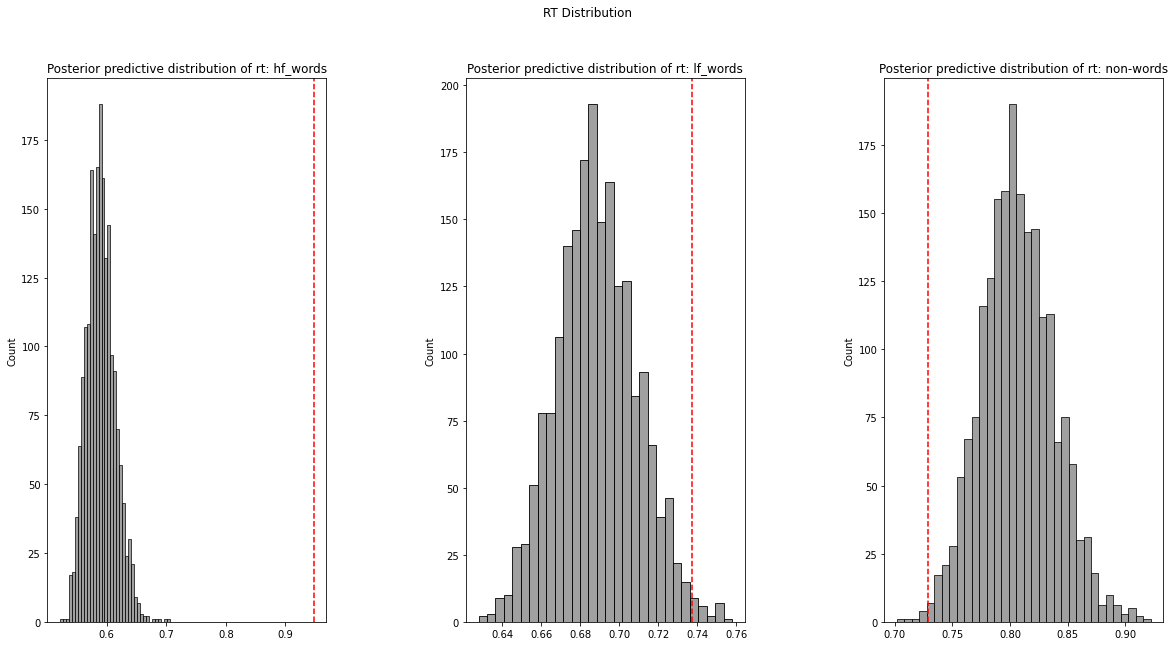

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

fig.suptitle('RT Distribution')
axes[0].set_title('Posterior predictive distribution of rt: hf_words')
axes[1].set_title('Posterior predictive distribution of rt: lf_words')
axes[2].set_title('Posterior predictive distribution of rt: non-words')


sns.histplot(ax=axes[0], data = np.mean(HF_words_rt, axis=1), color='grey')
axes[0].axvline(np.mean(hf_words_rt_real), color='red', linestyle='--');

sns.histplot(ax=axes[1], data = np.mean(LF_words_rt, axis=1), color='grey')
axes[1].axvline(np.mean(lf_words_rt_real), color='red', linestyle='--');

sns.histplot(ax=axes[2], data = np.mean(non_words_rt, axis=1), color='grey')
axes[2].axvline(np.mean(non_words_rt_real), color='red', linestyle='--');

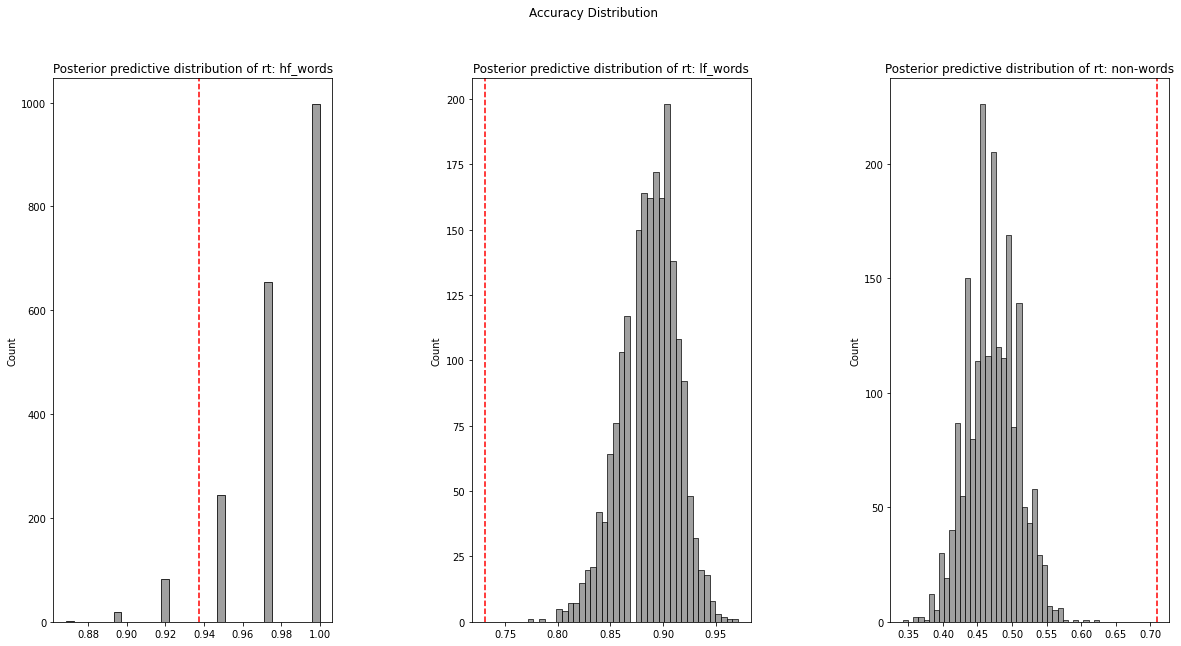

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20,10))
plt.subplots_adjust(wspace=0.5, hspace=0.5)

fig.suptitle('Accuracy Distribution')
axes[0].set_title('Posterior predictive distribution of rt: hf_words')
axes[1].set_title('Posterior predictive distribution of rt: lf_words')
axes[2].set_title('Posterior predictive distribution of rt: non-words')


sns.histplot(ax=axes[0], data = np.mean(HF_words_acc, axis=1), color='grey')
axes[0].axvline(np.mean(hf_words_acc_real), color='red', linestyle='--');

sns.histplot(ax=axes[1], data = np.mean(LF_words_acc, axis=1), color='grey')
axes[1].axvline(np.mean(lf_words_acc_real), color='red', linestyle='--');

sns.histplot(ax=axes[2], data = np.mean(non_words_acc, axis=1), color='grey')
axes[2].axvline(np.mean(non_words_acc_real), color='red', linestyle='--');